In [1]:
import pandas as pd
import numpy as np
import wrangle_mall
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer, RobustScaler, MinMaxScaler

In [2]:
# 1. Acquire data from mall_customers.customers in mysql database.
df = wrangle_mall.get_mall_data()

In [3]:
df.head()

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
# 2. Summarize data (include distributions and descriptive statistics).
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     200 non-null    int64 
 1   gender          200 non-null    object
 2   age             200 non-null    int64 
 3   annual_income   200 non-null    int64 
 4   spending_score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 9.4+ KB


In [5]:
df.describe()

,customer_id,age,annual_income,spending_score
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


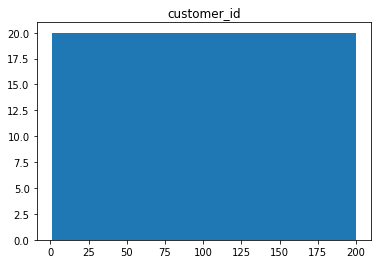

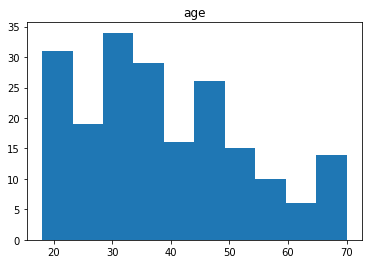

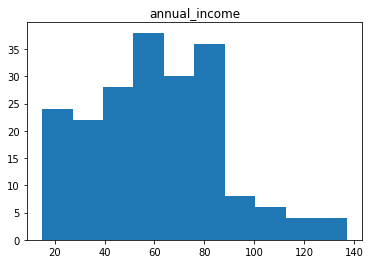

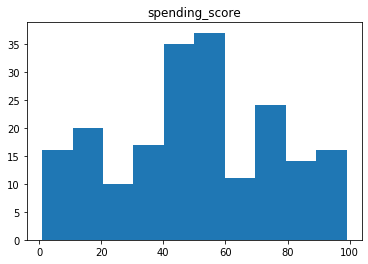

In [6]:
for col in df.columns:
    if df[col].dtype != object:
        plt.hist(df[col])
        plt.title(col)
        plt.show()

In [7]:
# 3. Detect outliers using IQR.
# we'll add a new column to the data frame that indicates the outliers in the numeric columns.
def get_upper_outliers(s, k):
    '''
    Given a series and a cutoff value, k, returns the upper outliers for the
    series.

    The values returned will be either 0 (if the point is not an outlier), or a
    number that indicates how far away from the upper bound the observation is.
    '''
    q1, q3 = s.quantile([.25, .75])
    iqr = q3 - q1
    upper_bound = q3 + k * iqr
    return s.apply(lambda x: max([x - upper_bound, 0]))


def add_upper_outlier_columns(df, k):
    '''
    Add a column with the suffix _outliers for all the numeric columns
    in the given dataframe.
    '''
    # outlier_cols = {col + '_outliers': get_upper_outliers(df[col], k)
    #                 for col in df.select_dtypes('number')}
    # return df.assign(**outlier_cols)

    for col in df.select_dtypes('number'):
        df[col + '_outliers'] = get_upper_outliers(df[col], k)

    return df

add_upper_outlier_columns(df, k=1.5)
df.head()

,customer_id,gender,age,annual_income,spending_score,customer_id_outliers,age_outliers,annual_income_outliers,spending_score_outliers
0,1,Male,19,15,39,0,0,0.0,0
1,2,Male,21,15,81,0,0,0.0,0
2,3,Female,20,16,6,0,0,0.0,0
3,4,Female,23,16,77,0,0,0.0,0
4,5,Female,31,17,40,0,0,0.0,0


In [8]:
#Now we can see what the outliers in our data look like:
outlier_cols = [col for col in df if col.endswith('_outliers')]
for col in outlier_cols:
    print('~~~\n' + col)
    data = df[col][df[col] > 0]
    print(data.describe())

~~~
customer_id_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: customer_id_outliers, dtype: float64
~~~
age_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: age_outliers, dtype: float64
~~~
annual_income_outliers
count    2.00
mean     4.25
std      0.00
min      4.25
25%      4.25
50%      4.25
75%      4.25
max      4.25
Name: annual_income_outliers, dtype: float64
~~~
spending_score_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: spending_score_outliers, dtype: float64


## Note there are 2 outliers in the annual income with a mean of 4.25.

In [9]:
# Have a binary gender column. Everything else is numeric. Going to change gender to numeric
df.head()

,customer_id,gender,age,annual_income,spending_score,customer_id_outliers,age_outliers,annual_income_outliers,spending_score_outliers
0,1,Male,19,15,39,0,0,0.0,0
1,2,Male,21,15,81,0,0,0.0,0
2,3,Female,20,16,6,0,0,0.0,0
3,4,Female,23,16,77,0,0,0.0,0
4,5,Female,31,17,40,0,0,0.0,0


In [10]:
#5. Encode categorical columns using a one hot encoder. I used dummies
dummies_df = pd.get_dummies(df[['gender']], drop_first=True)

In [11]:
#will rename to get all lowercase letters
dummies_df.head()

,gender_Male
0,1
1,1
2,0
3,0
4,0


In [12]:
dummies_df = dummies_df.rename(columns={'gender_Male': 'gender_male'})

In [13]:
# axis =1 is concat on columns. Going to get rid of customer id and gender
df = pd.concat([df,dummies_df], axis=1)
df.head()

,customer_id,gender,age,annual_income,spending_score,customer_id_outliers,age_outliers,annual_income_outliers,spending_score_outliers,gender_male
0,1,Male,19,15,39,0,0,0.0,0,1
1,2,Male,21,15,81,0,0,0.0,0,1
2,3,Female,20,16,6,0,0,0.0,0,0
3,4,Female,23,16,77,0,0,0.0,0,0
4,5,Female,31,17,40,0,0,0.0,0,0


In [14]:
df = df.drop(columns=['customer_id', 'gender'])

In [15]:
df.head()

,age,annual_income,spending_score,customer_id_outliers,age_outliers,annual_income_outliers,spending_score_outliers,gender_male
0,19,15,39,0,0,0.0,0,1
1,21,15,81,0,0,0.0,0,1
2,20,16,6,0,0,0.0,0,0
3,23,16,77,0,0,0.0,0,0
4,31,17,40,0,0,0.0,0,0


In [16]:
#4 Split data (train, validate, and test split).
train_and_validate, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train_and_validate, test_size=.3, random_state=123)

In [17]:
train.head()

,age,annual_income,spending_score,customer_id_outliers,age_outliers,annual_income_outliers,spending_score_outliers,gender_male
123,39,69,91,0,0,0.0,0,1
76,45,54,53,0,0,0.0,0,0
171,28,87,75,0,0,0.0,0,1
10,67,19,14,0,0,0.0,0,1
35,21,33,81,0,0,0.0,0,0


In [18]:
#6 handle missing values. No missing values
df.isna().sum()

age                        0
annual_income              0
spending_score             0
customer_id_outliers       0
age_outliers               0
annual_income_outliers     0
spending_score_outliers    0
gender_male                0
dtype: int64

In [19]:
#7 scaling
def add_scaled_columns(train, validate, test, scaler, columns_to_scale):
    """This function scales the mall customers data"""
    new_column_names = [c + '_scaled' for c in columns_to_scale]
    scaler.fit(train[columns_to_scale])

    train = pd.concat([
        train,
        pd.DataFrame(scaler.transform(train[columns_to_scale]), columns=new_column_names, index=train.index),
    ], axis=1)
    validate = pd.concat([
        validate,
        pd.DataFrame(scaler.transform(validate[columns_to_scale]), columns=new_column_names, index=validate.index),
    ], axis=1)
    test = pd.concat([
        test,
        pd.DataFrame(scaler.transform(test[columns_to_scale]), columns=new_column_names, index=test.index),
    ], axis=1)
    
    return train, validate, test
train.head()

,age,annual_income,spending_score,customer_id_outliers,age_outliers,annual_income_outliers,spending_score_outliers,gender_male
123,39,69,91,0,0,0.0,0,1
76,45,54,53,0,0,0.0,0,0
171,28,87,75,0,0,0.0,0,1
10,67,19,14,0,0,0.0,0,1
35,21,33,81,0,0,0.0,0,0


In [20]:
scaler = MinMaxScaler()
columns_to_scale = ['age','annual_income','spending_score']
train, validate, test = add_scaled_columns(train, validate, test, scaler, columns_to_scale)
train

,age,annual_income,spending_score,customer_id_outliers,age_outliers,annual_income_outliers,spending_score_outliers,gender_male,age_scaled,annual_income_scaled,spending_score_scaled
123,39,69,91,0,0,0.0,0,1,0.403846,0.442623,0.957447
76,45,54,53,0,0,0.0,0,0,0.519231,0.319672,0.553191
171,28,87,75,0,0,0.0,0,1,0.192308,0.590164,0.787234
10,67,19,14,0,0,0.0,0,1,0.942308,0.032787,0.138298
35,21,33,81,0,0,0.0,0,0,0.057692,0.147541,0.851064
...,...,...,...,...,...,...,...,...,...,...,...
175,30,88,86,0,0,0.0,0,0,0.230769,0.598361,0.904255
101,49,62,48,0,0,0.0,0,0,0.596154,0.385246,0.500000
148,34,78,22,0,0,0.0,0,0,0.307692,0.516393,0.223404
99,20,61,49,0,0,0.0,0,1,0.038462,0.377049,0.510638
